## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import patsy

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression





---

## Step 2: Obtain the data.

### 1. Read in the data.

In [168]:
# Read in data.
df = pd.read_csv('./chronic_kidney_disease_full.csv')

In [169]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [170]:
df.shape

(400, 25)

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: I'd like to examine the relationship between someone's age, blood pressure, red blood cell count, sodium, potassium, white blood cell count and whether or not they exhibit symptoms of/have CKD.

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [171]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [172]:

df_drop = df.dropna()

In [173]:
df_drop.shape

(158, 25)

In [174]:
158/400

0.395

Answer:
<br>58 rows remain.

<br>Dropping rows with missing data could lead to us  losing the data in the columns that do have valid values.

<br>We may drop too much of our data for the remaining data to be considered a random sample.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:
1. Any features that involve human measurement may contain human error, i.e. faulty practices.
2. Some records may have been mistakenly adjusted/rounded/recorded incorrectly.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer:
<br>Build a model that tells everyone that they have CKD 
<br>The only error that could occur is a Type I Error, or a False Positive.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: 
<br>We optimized Sensitivity and the False Negative Rate by minimizing False Negatives

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: 
<br>A model that comes up with a high amount of false positives will only lead to unnecessary stress and worry to patients.
<br>Also patients end up wasting resources on treatment.



### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: 
<br>Build a model that tells everyone that they do not have CKD
<br>the only error that could occur is a Type II Error, or a False Negative.



### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: 
We optimized Specificity and the False Positive Rate by minimizing False Positives.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: 
<br>a lot of sick people  believe they are not sick and not take any action to help themselves, until its to late
AND THEY DIE!!!!

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [175]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [176]:
#class is the target


In [177]:
#Just to see how many of each we have :)
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns

print(f"Numerical features : {str(len(numerical_features))}")
print(f"Categorical features : {str(len(categorical_features))}")
train_num = df[numerical_features]
train_cat = df[categorical_features]
#correct as per data dictionary

Numerical features : 14
Categorical features : 11


In [178]:
#dealing with the nans in numerical
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 14 columns):
age     391 non-null float64
bp      388 non-null float64
sg      353 non-null float64
al      354 non-null float64
su      351 non-null float64
bgr     356 non-null float64
bu      381 non-null float64
sc      383 non-null float64
sod     313 non-null float64
pot     312 non-null float64
hemo    348 non-null float64
pcv     329 non-null float64
wbcc    294 non-null float64
rbcc    269 non-null float64
dtypes: float64(14)
memory usage: 43.9 KB


In [179]:
#drop wbcc and rbcc as filling in 30% of values with na might skew results
train_num=train_num.drop(['wbcc','rbcc'],axis=1)

In [180]:
#fill nas with median values
train_num.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0


In [181]:
train_num.groupby('su').size() #most have sugar level 0, so can drop

su
0.0    290
1.0     13
2.0     18
3.0     14
4.0     13
5.0      3
dtype: int64

In [182]:
train_num=train_num.drop('su',axis=1)

In [183]:
#fill nas with median values
train_num = train_num.fillna(train_num.median())

In [184]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif_(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

    maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
        variables = np.delete(variables, maxloc)
        dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [185]:
calculate_vif_(train_num)

dropping 'sg' at index: 2
Remaining variables:
Index(['age', 'bp', 'al', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv'], dtype='object')


,age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv
0,48.0,80.0,1.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0
1,7.0,50.0,4.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0
2,62.0,80.0,2.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0
3,48.0,70.0,4.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0
4,51.0,80.0,2.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0
...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0
396,42.0,70.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0
397,12.0,80.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0
398,17.0,60.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0


In [186]:
train_num=train_num[['age', 'bp', 'al', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv']]

In [187]:
#look into train_cat
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
htn      398 non-null object
dm       398 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
class    400 non-null object
dtypes: object(11)
memory usage: 34.5+ KB


In [188]:
train_cat.rbc.unique() #too many entries without a rbc count, cannot assume its normal or abnormal so drop
train_cat=train_cat.drop(['rbc','pc'],axis=1)

In [189]:
for i in train_cat:
    print(train_cat[i].unique())  #nan values assume the lack of something,so replace them with the 

['notpresent' 'present' nan]
['notpresent' 'present' nan]
['yes' 'no' nan]
['yes' 'no' nan]
['no' 'yes' nan]
['good' 'poor' nan]
['no' 'yes' nan]
['no' 'yes' nan]
['ckd' 'notckd']


In [190]:
train_cat.columns

Index(['pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class'], dtype='object')

In [191]:
train_cat['pcc']=train_cat['pcc'].fillna('notpresent')
train_cat['ba']=train_cat['ba'].fillna('notpresent')
train_cat['htn']=train_cat['htn'].fillna('no')
train_cat['dm']=train_cat['dm'].fillna('no')
train_cat['cad']=train_cat['cad'].fillna('no')
train_cat['appet']=train_cat['appet'].fillna('poor')
train_cat['pe']=train_cat['pe'].fillna('no')
train_cat['ane']=train_cat['ane'].fillna('no')

In [192]:
for i in train_cat:
    print(train_cat[i].unique())

['notpresent' 'present']
['notpresent' 'present']
['yes' 'no']
['yes' 'no']
['no' 'yes']
['good' 'poor']
['no' 'yes']
['no' 'yes']
['ckd' 'notckd']


In [193]:
train_cat1=train_cat

In [194]:
train_cat1.pcc=train_cat1.pcc.replace(to_replace=['notpresent','present'], value=[1, 0])
train_cat1.ba=train_cat1.ba.replace(to_replace=['notpresent','present'], value=[1, 0])

In [195]:
train_cat1.htn=train_cat1.htn.replace(to_replace=['no','yes'], value=[1, 0])
train_cat1.dm=train_cat1.dm.replace(to_replace=['no','yes'], value=[1, 0])
train_cat1.cad=train_cat1.cad.replace(to_replace=['no','yes'], value=[1, 0])
train_cat1.pe=train_cat1.pe.replace(to_replace=['no','yes'], value=[1, 0])
train_cat1.ane=train_cat1.ane.replace(to_replace=['no','yes'], value=[1, 0])


In [196]:
train_cat1.appet=train_cat1.appet.replace(to_replace=['poor','good'], value=[0, 1])

In [197]:
train_cat1['class']=train_cat1['class'].replace(to_replace=['notckd','ckd'], value=[0, 1])

In [198]:
train_cat1

,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,1,1,0,0,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1
2,1,1,1,0,1,0,1,0,1
3,0,1,0,1,1,0,0,0,1
4,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
395,1,1,1,1,1,1,1,1,0
396,1,1,1,1,1,1,1,1,0
397,1,1,1,1,1,1,1,1,0
398,1,1,1,1,1,1,1,1,0


In [199]:
#checking all the cats are binary
for i in train_cat1:
    print(train_cat1[i].unique())

[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]


In [200]:
#joining them together
df2=train_num.join(train_cat1)

In [201]:
df2.head()

,age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,1,1,0,0,1,1,1,1,1
1,7.0,50.0,4.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,1,1,1,1,1,1,1,1,1
2,62.0,80.0,2.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,1,1,1,0,1,0,1,0,1
3,48.0,70.0,4.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,0,1,0,1,1,0,0,0,1
4,51.0,80.0,2.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,1,1,1,1,1,1,1,1,1


In [202]:
df2.isnull().sum()

age      0
bp       0
al       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
pcc      0
ba       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

In [203]:
df2.groupby('al').size()

al
0.0    245
1.0     44
2.0     43
3.0     43
4.0     24
5.0      1
dtype: int64

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [221]:
X=df2.drop('class',axis=1)
y=df2['class']

In [205]:
#poly = PolynomialFeatures(include_bias=False, degree=2)
#X_poly = poly.fit_transform(X)

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8, random_state = 42)

In [207]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [208]:
logreg = LogisticRegression()

In [209]:
logreg.fit(X_train, y_train)

/Users/ikhyvicky/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ikhyvicky/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [210]:
logreg.score(X_train, y_train)

0.978125

In [211]:
logreg.score(X_test, y_test)

0.9875

In [212]:
np.exp(logreg.coef_)

array([[ 0.98828521,  1.09093267,  5.87976214,  1.04659306,  0.98446811,
        11.15209673,  1.06414486,  1.46392951,  0.26415241,  0.90602572,
         1.01413533,  1.11634731,  0.45856944,  0.44765158,  1.08954436,
         0.55036085,  0.52905593,  0.708567  ]])

For a one-unit change in age, means that chances of getting ckd as u get older is e^{0.876} times as likely.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

For a one-unit change in pcc, means that chances of getting ckd is e^{1.314} times as likely.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:
<br>1.Efficient, does not require too many computational resources, it’s <br>highly interpretable
<br>2.It doesn’t require input features to be scaled, it doesn’t require <br>any tuning, it’s easy to regularize, and it outputs well-calibrated <br>predicted probabilities.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [213]:
pred=logreg.predict(X_test)

In [214]:
#show predicted 
pred

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0])

In [215]:
y_test[:10]

,class
209,1
280,0
33,1
210,1
93,1
84,1
329,0
94,1
266,0
126,1


In [216]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)

In [217]:
cm

array([[27,  1],
       [ 0, 52]])

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: If we choose specifity, we are trying to maximise true positives <br>and minimising our false positives. We are then leaving a potential <br>risk for missing those who according to our model are are on the <br>border line and may or may not have the disease
<br>If we choose sensitivity, we maximise false positives ,and minimise <br>false negatives. We are telling people they are okay when they <br>actually have CKD

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [224]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in logreg.predict_proba(X_test)]
pred_df=pd.DataFrame(pred_proba,columns=['pred_probs'])
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
209,1,0.890088
280,0,0.066845
33,1,1.000000
210,1,1.000000
93,1,1.000000
...,...,...
246,1,1.000000
227,1,0.995239
369,0,0.020568
176,1,1.000000


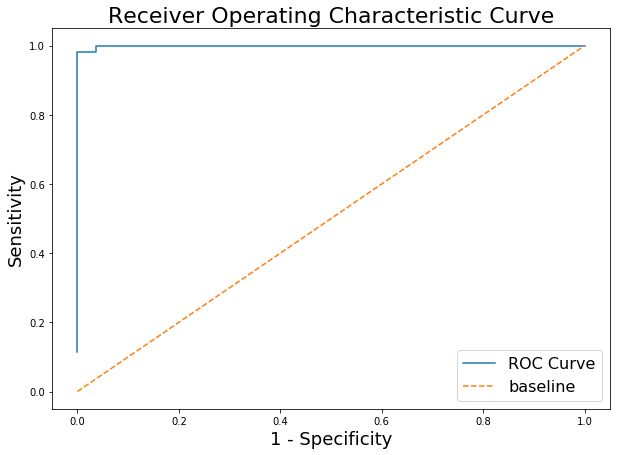

In [225]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: In our instance we are saying that there is no CKD when we know <br>that to not be true. So if assume there is no CKD, that can actually <br>lead to a lot of CKD going undiagnosed.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: Same answer as above

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [52]:
df2[df2['class']==1].shape

(250, 19)

In [53]:
testing=df2[df2['class']==1]
testing

,age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.0,121.0,36.0,1.2,138.0,4.4,15.40,44.0,1,1,0,0,1,1,1,1,1
1,7.0,50.0,4.0,121.0,18.0,0.8,138.0,4.4,11.30,38.0,1,1,1,1,1,1,1,1,1
2,62.0,80.0,2.0,423.0,53.0,1.8,138.0,4.4,9.60,31.0,1,1,1,0,1,0,1,0,1
3,48.0,70.0,4.0,117.0,56.0,3.8,111.0,2.5,11.20,32.0,0,1,0,1,1,0,0,0,1
4,51.0,80.0,2.0,106.0,26.0,1.4,138.0,4.4,11.60,35.0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,48.0,100.0,0.0,103.0,79.0,5.3,135.0,6.3,6.30,19.0,1,1,0,1,0,0,1,1,1
246,48.0,110.0,3.0,106.0,215.0,15.2,120.0,5.7,8.60,26.0,0,1,0,1,0,1,1,0,1
247,54.0,90.0,1.0,150.0,18.0,1.2,140.0,4.2,12.65,40.0,1,1,1,1,1,0,0,0,1
248,59.0,70.0,1.0,424.0,55.0,1.7,138.0,4.5,12.60,37.0,1,1,0,0,0,1,1,1,1


In [54]:
import random
random.seed(42)
bs_sample1=testing.sample(n=200000,replace=True)

In [55]:
bs_sample1

,age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv,pcc,ba,htn,dm,cad,appet,pe,ane,class
143,41.0,80.0,1.0,210.0,165.0,18.0,135.0,4.7,12.65,40.0,1,1,1,0,1,1,1,1,1
169,55.0,70.0,0.0,220.0,68.0,2.8,138.0,4.4,8.70,27.0,1,1,0,0,1,1,1,0,1
22,48.0,80.0,4.0,95.0,163.0,7.7,136.0,3.8,9.80,32.0,1,1,0,1,1,1,1,0,1
95,62.0,90.0,1.0,94.0,25.0,1.1,131.0,3.7,12.65,40.0,1,1,0,1,1,1,0,0,1
34,70.0,70.0,1.0,171.0,153.0,5.2,138.0,4.4,12.65,40.0,0,0,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,61.0,60.0,0.0,108.0,75.0,1.9,141.0,5.2,9.90,29.0,1,1,0,0,1,1,1,0,1
191,55.0,70.0,3.0,110.0,115.0,6.0,134.0,2.7,9.10,26.0,1,1,0,0,1,0,1,1,1
56,76.0,70.0,3.0,121.0,164.0,9.7,131.0,4.4,10.20,30.0,0,1,0,0,0,0,0,1,1
159,59.0,80.0,1.0,303.0,35.0,1.3,122.0,3.5,10.40,35.0,1,1,1,0,1,0,1,1,1


In [56]:
df2.head()

,age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,1,1,0,0,1,1,1,1,1
1,7.0,50.0,4.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,1,1,1,1,1,1,1,1,1
2,62.0,80.0,2.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,1,1,1,0,1,0,1,0,1
3,48.0,70.0,4.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,0,1,0,1,1,0,0,0,1
4,51.0,80.0,2.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,1,1,1,1,1,1,1,1,1


In [57]:
df3=pd.concat([df2,bs_sample1],ignore_index=True)

In [58]:
df3

,age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,1,1,0,0,1,1,1,1,1
1,7.0,50.0,4.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,1,1,1,1,1,1,1,1,1
2,62.0,80.0,2.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,1,1,1,0,1,0,1,0,1
3,48.0,70.0,4.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,0,1,0,1,1,0,0,0,1
4,51.0,80.0,2.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200395,61.0,60.0,0.0,108.0,75.0,1.9,141.0,5.2,9.9,29.0,1,1,0,0,1,1,1,0,1
200396,55.0,70.0,3.0,110.0,115.0,6.0,134.0,2.7,9.1,26.0,1,1,0,0,1,0,1,1,1
200397,76.0,70.0,3.0,121.0,164.0,9.7,131.0,4.4,10.2,30.0,0,1,0,0,0,0,0,1,1
200398,59.0,80.0,1.0,303.0,35.0,1.3,122.0,3.5,10.4,35.0,1,1,1,0,1,0,1,1,1


### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [59]:
X1=df3.drop('class',axis=1)
y1=df3[['class']]

In [60]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1,train_size=0.8, random_state=42)


In [61]:
bs_lr = LogisticRegression()
bs_lr.fit(X1_train, y1_train)

/Users/ikhyvicky/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ikhyvicky/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
pred1=bs_lr.predict(X1_test)

In [63]:
cm1=confusion_matrix(y1_test,pred1)

In [64]:
cm1

array([[   31,     8],
       [    0, 40041]])

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!